In [1]:
#|default_exp augment

# Augmentation

In [2]:
#|export
import torch
import random
import fastcore.all as fc

from torch import nn
from torch.nn import init

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import * 
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *

In [3]:
import torch.nn.functional as F
from functools import partial
import matplotlib.pyplot as plt
from torch import tensor, optim
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset
from fastcore.test import test_close
import torchvision.transforms.functional as TF

import logging; logging.disable(logging.WARNING)

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
plt.style.use('fast')


In [6]:
xl, yl = 'image', 'label'
name = "fashion_mnist"
bs = 1024
xmean, xstd = 0.29, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o) - xmean)/xstd for o in b[xl]]

dsd = load_dataset(name)
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, batch_size=bs, num_workers=fc.defaults.cpus)

  0%|          | 0/2 [00:00<?, ?it/s]

In [8]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralReLU))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
act_gr = partial(GeneralReLU, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)
set_seed(42)

In [9]:
def get_model(act=GeneralReLU, nfs=(16, 32, 64, 128, 256, 512), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, stride=2) for i in range(len(nfs)-1)]
    layers += [nn.Flatten(), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]

    return nn.Sequential(*layers)

In [13]:
lr, epochs = 1e-1, 5
tmax = epochs * len(dls.train)
sched = partial(optim.lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra_cbs = [BatchSchedCB(sched)]
learn = Learner(get_model().apply(iw), dls, F.cross_entropy, lr=lr, cbs=cbs+xtra_cbs, opt_func=optim.AdamW)

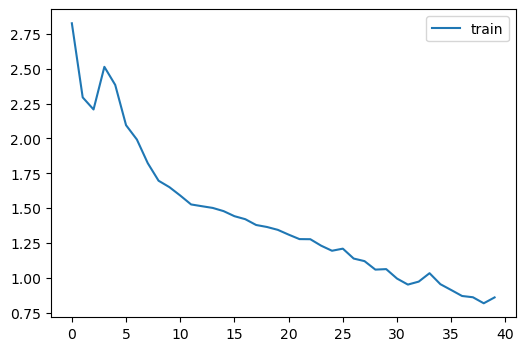

KeyboardInterrupt: 

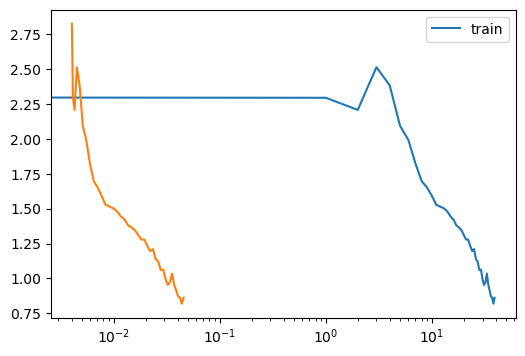

In [14]:
learn.lr_find(start_lr=1e-3)